In [1]:
%reload_ext autoreload
%autoreload 2

import notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.adjudication_multi_candidate_utils as acu
# or: from notebooks_utils import adjudication_multi_candidate_utils as acu  # also a module object

import importlib; importlib.reload(acu)   # works

<module 'notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.adjudication_multi_candidate_utils' from '/Users/dorfuchs/Documents/Projects/main_project/over-intra-news/src/notebooks_utils/data_notebooks_utils/adjudication_multi_candidate/adjudication_multi_candidate_utils.py'>

# 1 Ticker → CIK Mapping with High-Signal SEC Filings

## 1.1 TL;DR

- The goal of this notebook is to produce a curated `ticker_cik_mapping` table with exactly one primary CIK per `(ticker, validity_window)` episode in the S&P 500 universe.
- Evidence is restricted to a high-precision subset of EDGAR filings (periodic reports and a curated slice of 8-K items), plus pre-derived Wayback-based S&P 500 membership windows.
- Simple auto-accept rules based on periodic coverage resolve the vast majority of episodes; a residual set of ambiguous cases is handed off to manual adjudication and recorded in `ticker_cik_manual_adjudication`.
- The final mapping is fully auditable: each manual decision stores a rationale, sources, and a representative `evidence_id` (or sentinel) linking back to the underlying evidence tables.


## 1.2 Background and motivation

This notebook builds the time-varying map from S&P 500 tickers to SEC Central Index Key (CIK) identifiers that are needed in order to faithfully recreate
'Does Overnight News Explain Overnight Returns?' (Glasserman, Krstovski, Laliberte and Mamaysky July 2025). Their paper works with CRSP index membership and commercial security master data; This pipeline tries to recreate the same object using only public sources:

- The GitHub repository https://github.com/fja05680/sp500 is used to create *ticker*-based S&P 500 constituency windows.
- Candidate CIKs are then seeded into the pipeline by scraping the WayBack machine's snapshots of the Wikipedia page: "List of S&P 500 companies"<sup>[1](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)</sup> that lie within each ticker constituency windows.
- Evidence is gathered in the form of SEC EDGAR filings to identify which legal entity (CIK) underlies each (ticker, validity_window) episode.

The goal is a research-grade firm panel that matches the spirit of the original paper—firm-level news exposures and return decompositions—without relying on proprietary security master or index-constituent datasets.

A central challenge is entity resolution. For many S&P 500 episodes there is a unique, obvious issuer CIK; for others, EDGAR presents several plausible candidates (parent vs. subsidiary, pre- and post-merger entities, or stray CIKs that only appear in ownership filings). In an earlier attempt a very broad filing set was used, pulling in almost any form that mentioned the ticker. That approach produced a large, noisy evidence table and too many ambiguous (ticker, window, candidate_cik) triples.

This version is restarted from a much smaller, high-signal evidence set, focusing only on filing types that reliably anchor the identity of the listed operating company.

## 1.3 Evidence set and “eligible” form types

Let `ticker_cik_evidence` denote the table of candidate links between a ticker, a validity window, and a CIK, together with the filings that support each link. In its current iteration, this table only contains form types out of the following restricted set to answer the question:

> Which legal entity was the actual listed issuer for ticker X in window [start, end)?

The eligible forms fall into two buckets.

### Periodic reports (ongoing issuer identity)

These are the backbone of the evidence set. They are long-form financial reports that can only be filed by the registrant itself, and they typically restate the legal name, state/country of incorporation, and exchange listing.

- Form 10-K / 10-K/A / 10-KT – Annual reports of U.S. issuers. See the SEC’s description of Form 10-K: <sup>[2](https://www.sec.gov/forms/10-k)</sup>
- Form 10-Q / 10-Q/A / 10-QT – Quarterly reports of U.S. issuers. See Form 10-Q: <sup>[3](https://www.sec.gov/forms/10-q)</sup>
- Form 20-F / 20-F/A – Annual reports for foreign private issuers, often the right anchor when the S&P 500 constituent is a non-U.S. company listed via ordinary shares or ADRs. See Form 20-F: <sup>[4](https://www.sec.gov/forms/20-f)</sup>

In the code these drive a boolean feature

  ```text
    has_periodic := form_type ∈ {
        10-K, 10-KT, 10-K/A,
        10-Q, 10-QT, 10-Q/A,
        20-F, 20-F/A
    }
  ```

which is the main signal for “this CIK is behaving like the actual issuer over this window.”

### Selected 8-K current reports (mid-window structural changes)

Form 8-K is a short “current report” used to disclose material events between periodic reports.<sup>[5](https://www.sec.gov/forms/8-k)</sup>

Most 8-Ks are about earnings releases or routine updates and are not useful for identity. Therefore only 8-Ks whose item codes indicate a structural change in the security or issuer that could cause a mid-window split, ticker change, or change in the underlying legal entity are ingested as evidence.

Concretely, the eligible 8-K items are:

- Item 1.01 – Entry into a Material Definitive Agreement (often merger agreements, significant asset purchases/sales, or credit facilities that precede a reorganization).
- Item 2.01 – Completion of Acquisition or Disposition of Assets (used when a merger or major asset acquisition closes and the surviving registrant is identified).
- Item 3.03 – Material Modification to Rights of Security Holders (captures changes in share classes, voting rights, or similar corporate actions).
- Item 5.01 – Changes in Control of Registrant.
- Item 5.03 – Amendments to Articles of Incorporation or Bylaws; Change in Fiscal Year.

These items tend to say things like “Company A merged with Company B, with Company B as the surviving corporation,” or “the registrant’s common stock began trading under the new ticker XYZ on the New York Stock Exchange.” Those statements are exactly what is needed to decide whether a CIK should own the full S&P 500 window or whether the window must be split around a corporate event.

Operationally, the evidence pipeline now:

1. Ingests periodic reports and a small, curated subset of 8-Ks with one or more of the above items.
2. Discards all other form types (13D/G, proxy statements, shelf registrations, etc.) for the purpose of issuer identity, even though they are still available in EDGAR.
3. Computes features like `has_periodic` per (ticker, validity_window, candidate_cik) group to support deterministic auto-accept rules later in the notebook.

This trimmed evidence set dramatically reduces noise while still retaining the filings that actually state who the registrant is and when that identity changes.

## 1.4 Manual adjudication and the ticker_cik_manual_adjudication table

Even with the refined form set, some (ticker, validity_window) pairs remain ambiguous:

- The Wayback-scraped S&P 500 table sometimes picks up stray CIKs that belong to insiders or completely unrelated micro-cap issuers.
- Corporate restructurings can produce pairs of closely related CIKs (e.g., pre- and post-inversion entities) that both have legitimate filings in or near the window.
- A few candidates have no in-window eligible filings at all (for example, a defunct issuer that only files a revocation order years later).

In these cases the underlying EDGAR filings and contemporaneous Wayback snapshots were reviewed and the result was recorded in a dedicated adjudication table:

    ```sql
    ticker_cik_manual_adjudication(
        ticker           TEXT,
        validity_window  DATERANGE,
        associated_cik   TEXT,   -- 10-digit CIK this decision is about
        action           TEXT,   -- e.g. 'manual_override'
        rationale        TEXT,   -- human-readable explanation
        sources          TEXT[], -- EDGAR / Wayback URLs
        evidence_id      BIGINT  -- optional pointer back into ticker_cik_evidence
    )
    ```

The `action` column encodes a small, fixed set of decision types:

- `seed_with_cik` – seed a `(ticker, validity_window)` episode with an explicit `associated_cik` when automated harvesting is ambiguous or incomplete.
- `manual_override` – override a candidates validity for a specific `(ticker, validity_window, associated_cik)` triple (e.g., force-include or force-exclude a candidate CIK based on external evidence).
- `window_split` – split a coarse S&P 500 validity window into multiple sub-windows, each tied to a different `associated_cik`.
- `alias_rewrite` – record ticker-level alias rewrites (symbol changes where the underlying issuer does not change); in this case `associated_cik` is `NULL` by construction.

These actions form a small state machine for tricky episodes and provide a stable surface for downstream consumers to reason about manual decisions.


A few examples:

- JKHY — spurious insider CIK.  
  Wikipedia snapshots briefly listed Jack Henry & Associates (JKHY) with CIK 0001262439, but EDGAR shows that CIK only as a Form 4 / Schedule 13D filer in the mid-2000s, never as the issuer of 10-K/10-Q/8-K/registration forms. The actual S&P 500 issuer is CIK 0000779152. A `manual_override` row for 0001262439 was recorded, with a rationale explaining that it is an insider identifier that should be excluded from the mapping in this window.

- AOS — unrelated micro-cap issuer.  
  For ticker AOS the Wayback data produced a candidate 0001391407, which EDGAR identifies as BIOFUELS POWER CORP. Its only filing in the relevant horizon is a “REVOKED” order revoking registration for failure to file periodic reports; there is no evidence linking it to A. O. Smith Corp (CIK 0000091142) or to any S&P 500 listing. Here the manual override explicitly marks 0001391407 as a stray candidate to be ignored.

- MYL — Mylan Inc. vs. Mylan N.V.  
  For ticker MYL in [2016-08-01, 2020-11-17) the candidates are Mylan Inc. (0000069499) and Mylan N.V. (0001623613). Pre-window registration filings and 8-K correspondence show the corporate reorganization in which Mylan N.V. becomes the primary issuer, with Mylan Inc. acting as a guarantor. Within the window, the periodic reports are consistently filed under 0001623613, so the manual decision is to treat Mylan N.V. as the operating issuer for this S&P 500 episode and to treat Inc. as a related but non-primary entity.

The key point is that ticker_cik_manual_adjudication is not the final mapping itself. Instead, it encodes exceptions and curated decisions to be applied when deterministic rules are silent or misleading:

- Some rows exclude a candidate CIK as clearly spurious.
- Others alias or mark a true window split when sufficient evidence is found.

Downstream, the mapping algorithm treats any (ticker, validity_window, associated_cik) triple with `action = 'manual_override'` as already adjudicated and removes it from the pool of candidates that need to be ranked or resolved automatically. This keeps the final ticker → CIK map auditable: every non-obvious decision is backed either by an explicit rule or by a short, human-readable rationale and a list of source documents.


In [2]:
from typing import List
from dotenv import load_dotenv
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt

from infra.seeds.seed_evidence.loading.load_mapping_table import load_mapping_table
from notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.\
    adjudication_multi_candidate_utils import (
    filter_auto_accept
)
from notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.\
    adjudication_multi_candidate_config import (
    SENTINEL_TICKERS
)
from notebooks_utils.data_notebooks_utils.general_data_notebooks_utils import connect_with_sqlalchemy

load_dotenv()
engine: sa.Engine = connect_with_sqlalchemy()
keys: List[str] = ['ticker', 'validity_window']
query: str = (
"""
    SELECT *
    FROM ticker_cik_evidence;
"""
)
evidence_df: pd.DataFrame = pd.read_sql_query(query, engine)
sentinel_mask: pd.Series = evidence_df['ticker'].isin(SENTINEL_TICKERS)
evidence_df: pd.DataFrame = evidence_df[~sentinel_mask]

## 2 Auto-accept rules and canonical evidence selection

### 2.1 Auto-accept rules based on periodic filings

The goal of the rule set is to aggressively resolve the simpler cases while
leaving genuinely ambiguous ones for manual adjudication. The core signal is
the presence of *periodic* forms (10-K / 10-Q / 20-F and variants) inside the
(ticker, validity_window) horizon.

At the (ticker, validity_window, candidate_cik) level the has_periodic column is defined as:

    has_periodic := form_type ∈ {
        10-K, 10-KT, 10-K/A,
        10-Q, 10-QT, 10-Q/A,
        20-F, 20-F/A
    }

computed from the evidence table by checking whether the candidate has at least
one in-window filing in this set.

A **candidate triple** is defined as a unique (ticker, validity_window, candidate_cik). The auto-accept rules are:

#### Rule 1 — Single candidate with periodic filings

> If a (ticker, validity_window) has exactly one candidate CIK, and that
> candidate has at least one periodic filing in-window, auto-accept this
> mapping.

Operationally:

- Evidence is grouped by (ticker, validity_window).
- If a group has exactly one candidate CIK And `has_periodic` for that candidate is `True`
  (i.e., there is at least one 10-K / 10-Q / 20-F or allowed variant within the window).
- Then mark that candidate as the `winning_candidate` and skip manual review for
  this (ticker, window).

This captures the canonical case: only one legal entity is filing issuer-level
periodic reports over the S&P 500 episode, so it is overwhelmingly likely to be
the actual listed issuer.

Groups where the single candidate has **no** periodic filings
(e.g. only a revocation order or stray 8-K) are *not* auto-accepted and remain
in the “needs manual attention” bucket.

#### Rule 2 — Multiple candidates, unique periodic issuer

> If a (ticker, validity_window) has multiple candidate CIKs, and exactly one of
> them has any periodic filings in-window, auto-accept that candidate and reject
> the others.

Operationally:

- Evidence is grouped by (ticker, validity_window).
- Let `C_periodic` be the subset of candidate CIKs in the group with
  `has_periodic = True`.
- If `|C_periodic| = 1`, mark that single candidate as the `winning_candidate`
  for this (ticker, window) and treat the others as non-issuers for this
  episode.

This addresses patterns such as:

- Parent vs. financing vehicle / subsidiary, where only the parent files 10-K /
  10-Q / 20-F as registrant.
- A stray insider or unrelated micro-cap CIK that appears in Wayback, but has
  no periodic filings in the S&P 500 horizon, while the true S&P issuer does.

Groups where *multiple* candidates have periodic filings are intentionally left
unresolved by these rules and are handled separately.

**Illustrative examples of Rules 1 and 2**

For a fixed `(ticker, validity_window)`, the auto-accept rules behave as follows:

| ticker | validity_window           | candidate_cik | has_periodic | Outcome |
|--------|---------------------------|---------------|-------------:|---------|
| ABC    | [2016-08-01,2017-08-01)   | 0001111111    | TRUE         | Auto-accept via **Rule&nbsp;1** (single candidate with periodic evidence). |
| XYZ    | [2016-08-01,2017-08-01)   | 0002222222    | TRUE         | Auto-accept via **Rule&nbsp;2** (only candidate with periodic evidence). |
| XYZ    | [2016-08-01,2017-08-01)   | 0003333333    | FALSE        |         |
| QRS    | [2016-08-01,2017-08-01)   | 0004444444    | TRUE         | Not auto-accepted: multi-candidate / multi-periodic episode, forwarded to §3 for manual adjudication. |
| QRS    | [2016-08-01,2017-08-01)   | 0005555555    | TRUE         |         |

This table is purely illustrative but mirrors the structure of the actual `ticker_cik_evidence`–derived candidate sets that feed the rules.

### 2.2 Canonical evidence selection (`find_canonical_evidence`)

Once a `winning_candidate` has been identified for a given
(ticker, validity_window) — either via the auto-accept rules above or via
manual adjudication — A **single** filing needs to be chosen as the canonical
evidence record for that decision.

The helper `find_canonical_evidence(...)` operates on the evidence dataframe
and returns, for each evidence row, a `canonical_evidence_id` column that is
either the ID of the chosen canonical filing or `NaN` if the row is not the
canonical one.

The logic is:

1. **Scope to winning candidates (optional).**  
   When an `auto_accept_mask` is supplied, Rows are first restricted to  
   `auto_accept_mask == True` and `candidate_cik == winning_candidate`.  
   Canonical selection is then performed only for candidates that are already
   accepted.

2. **Assign a form-type score.**  
   Each `form_type` is mapped into an integer `form_score` using
   `PERIODIC_FORMS_EVIDENCE_HIERARCHY`, which encodes a ranking like:
   - 10-K / 10-K/A / 20-F / 20-F/A as highest-quality evidence,
   - then 10-Q / 10-Q/A / 10-QT,
   - then any lower-priority forms (if included, such as structural 8-Ks).

   Lower `form_score` means “better” evidence.

3. **Sort by best form, then latest filing.**  
   Within the restricted dataframe, sorting is done by  
   `(form_score ASC, filed_at DESC, evidence_id DESC)`.  
   This prioritizes:
   - higher-quality form types;
   - more recent filings within the window (so the canonical document reflects
     the most current corporate identity and listing status);
   - and uses `evidence_id` as a stable tie-breaker.

4. **Take the top-ranked filing per accepted candidate.**  
   The evidence is grouped by `(ticker, validity_window, candidate_cik)` and the first row
   is kept after sorting. This yields exactly one “canonical” evidence row per accepted
   candidate and window.

5. **Project back to the full evidence table.**  
   Finally, these canonical rows are left-joined back to the full `evidence_df`,
   producing a `canonical_evidence_id` series aligned with the original index.
   Non-canonical rows receive `NaN` in this column.

The resulting canonical evidence ID is stored alongside the final
(ticker, validity_window, candidate_cik) mapping and referenced from
`ticker_cik_manual_adjudication.evidence_id` (when used) so that every decision is backed by
a concrete filing.

In [ ]:
from notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.\
    adjudication_multi_candidate_utils import (
        find_canonical_evidence
    )


auto_accept_df: pd.DataFrame = filter_auto_accept(evidence_df)
auto_accept_mask: pd.Series = auto_accept_df['rule_1'] | auto_accept_df['rule_2']
auto_accept_canonical_evidence: pd.Series = find_canonical_evidence(
    auto_accept_df,
    keys,
    auto_accept_mask
)
auto_accept_mapping_df: pd.DataFrame = evidence_df[evidence_df['evidence_id'].isin(auto_accept_canonical_evidence)]
load_mapping_table(auto_accept_mapping_df) # Loads only if load is set to True


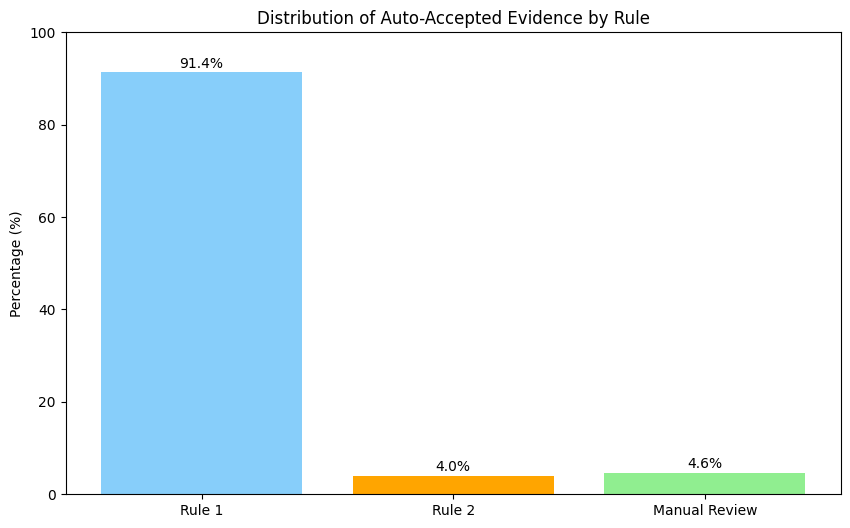

In [22]:
rule_1_df: pd.DataFrame = auto_accept_df[auto_accept_df['rule_1']]
rule_2_df: pd.DataFrame = auto_accept_df[auto_accept_df['rule_2']]
manual_review_df: pd.DataFrame = auto_accept_df[
    ~(auto_accept_df['rule_1'] | auto_accept_df['rule_2'])
]
labels: List[str] = ['Rule 1', 'Rule 2', 'Manual Review']
sizes: List[int] = [
    len(rule_1_df),
    len(rule_2_df),
    len(manual_review_df)
]
colors: List[str] = ['lightskyblue', 'orange', 'lightgreen']
total: int = sum(sizes)
percentages: List[int] = [(size / total) * 100 for size in sizes]
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages, color=colors)
plt.title('Distribution of Auto-Accepted Evidence by Rule')
plt.ylabel('Percentage (%)')
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 1, f"{percentage:.1f}%", ha="center", fontsize=10)
plt.ylim(0, 100)
plt.show()

## 3 Manual adjudication of remaining ticker–CIK pairs

### 3.1 Residual set after auto-accept rules

After applying the two auto-accept rules from §2 and stitching in previously
adjudicated seeds from `ticker_cik_manual_adjudication`, there remain
**17** unresolved `(ticker, validity_window)` pairs. These are exactly the
rows shown in the table below.

By construction, this residual set is the part of the universe where the
automatic logic is either *uninformative* or *potentially misleading*:

- For these pairs, the high-signal evidence set (periodic forms) does **not** produce a unique, obviously correct issuer.
- In particular, Rules 1 and 2 cannot safely pick a single `candidate_cik`
  based only on in-window periodic filings, even though the evidence table
  is otherwise complete for the run horizon.

This is intentional: the auto-accept rules are deliberately conservative, so
that clear cases are resolved mechanically and the remaining, genuinely
ambiguous episodes are escalated to manual review.

### 3.2 Two main ambiguity patterns

Empirically, the 17 unresolved pairs fall into two structural patterns:

1. **Single-candidate, no-periodic**

   - For a given `(ticker, validity_window)`, there is exactly one
     `candidate_cik` in `ticker_cik_evidence`.
   - However, this candidate has **no in-window periodic filings** in the
     restricted set  
     (`10-K`, `10-KT`, `10-K/A`, `10-Q`, `10-QT`, `10-Q/A`, `20-F`,
     `20-F/A`), i.e. `has_periodic = False` for that triple.

   This can arise for several reasons:

   - The S&P 500 **validity window is very short** (for example, a late
     addition followed by a merger or deletion), so the nearest 10-K/10-Q/20-F
     lies just outside the window.
   - The issuer was already public and fully reporting, but its last periodic
     report **predates the start** of the S&P window and no new periodic
     report is filed before the constituent is removed.
   - A structural or listing event is disclosed via an 8-K or registration
     statement, but that specific filing type is not part of the high-signal
     evidence set used to drive `has_periodic`.

   Because there is no in-window periodic anchor, the pipeline **cannot**
   auto-accept these without either:
   - broadening the evidence set (e.g., allowing certain registration forms
     or pre-window filings to drive the decision), or
   - relying on out-of-window filings plus Wayback snapshots as a curated,
     manual judgement.

   In this notebook, such episodes are left for **manual adjudication**:
   they will either be promoted into the final mapping via a
   `seed_with_cik` decision (backed by pre-/post-window filings and S&P
   documentation), or explicitly documented as edge cases.

2. **Multi-candidate, multi-periodic**

   - For a given `(ticker, validity_window)`, there are **multiple**
     `candidate_cik` values.
   - At least **two** of these candidates have `has_periodic = True`, i.e.
     more than one legal entity files in-window periodic reports that match
     the ticker or company name.

   This pattern almost always reflects some combination of:

   - A **true issuer succession or split** inside the coarse S&P 500 window  
     (e.g., pre- and post-merger entities, redomiciling from one jurisdiction
     to another, or holdco/opco reorganizations where the CIK changes).
   - A **corporate hierarchy** in which both a parent and a listed subsidiary
     file periodic reports, and the ticker appears in the narrative of
     each (for example, when a parent guarantees the debt of a listed
     subsidiary or vice versa).

   From the perspective of the auto-accept rules, these are precisely the
   cases where the “unique periodic issuer” signal breaks down: more than
   one CIK is behaving like a bona fide registrant over the window, so
   purely mechanical logic cannot reliably decide:

   - whether the window should be **split** into two episodes, each with a
     different CIK; or
   - whether one of the periodic filers is the **true** S&P 500 constituent
     and the other is a related, but non-primary, entity.

   These episodes are therefore **forced into manual review** rather than
   resolved by heuristic. In practice, they almost always trace back to
   well-documented corporate events (mergers, spin-offs, inversions, or
   changes of jurisdiction) that can be pinned down in 8-Ks and registration
   statements.

### 3.3 Manual review workflow for the 17 pairs

For each of the 17 `(ticker, validity_window)` pairs in this residual set,
the workflow is:

1. **Inspect all evidence rows** for that (ticker, window): list all
   `candidate_cik` values, their `has_periodic` flags, and the full set of
   in-window filings (form types, `filed_at`, company names).

2. For **single-candidate, no-periodic** cases:
   - Look just **outside the window** (immediately pre- and post-window
     10-K/10-Q/20-F filings) to confirm continuity of the legal entity.
   - Cross-check contemporaneous **S&P 500 documentation** (Wayback
     snapshots and index changes) to ensure the ticker–CIK association is not
     spurious.
   - If the evidence is consistent, record a `seed_with_cik` decision in
     `ticker_cik_manual_adjudication`, with a short rationale and URLs to the
     supporting filings and S&P references.

3. For **multi-candidate, multi-periodic** cases:
   - Read the relevant **structural filings** (8-Ks with Items 1.01, 2.01,
     3.03, 5.01, 5.03; registration statements; cross-referenced 10-K/20-F
     sections) to determine whether there is:
     - a genuine **window split** (the ticker migrates from one CIK to
       another mid-window), or
     - a **primary vs. non-primary** relationship (one CIK is consistently
       described as the listed issuer; the other as guarantor, parent, or
       subsidiary).
   - Encode the outcome in `ticker_cik_manual_adjudication` using
     `manual_override` or `window_split`,
     again with a short rationale and links to the key documents.

4. Once these decisions are in place, the curated manual rows are treated as
   **fixed constraints**: they are removed from any further automated
   candidate ranking, and the final `ticker_cik_mapping` table can be built
   by combining:
   - auto-accepted mappings from §2, and
   - manually adjudicated episodes from this section.

This ensures that the final mapping is both **systematic** (driven by simple,
transparent rules wherever possible) and **auditable** (every non-trivial
decision is backed by explicit manual reasoning and traceable sources).

Note on `MANUALLY_MAPPED_TICKERS`.

`MANUALLY_MAPPED_TICKERS` is a small, hard-coded set of five edge-case tickers that were already resolved during the ingestion phase. For these symbols, the underlying issuer was known, but no usable periodic or curated 8-K evidence fell inside the S&P&nbsp;500 validity window, or the available filings were not legible for the purposes of this notebook. They are therefore treated as pre-mapped here and excluded from the residual candidate set.

In [ ]:
from notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.\
    adjudication_multi_candidate_config import (
        MANUALLY_MAPPED_TICKERS
    )

mapped_mask: pd.Series = auto_accept_mask | (auto_accept_df['ticker'].isin(MANUALLY_MAPPED_TICKERS))
accepted_pairs: pd.Series = (
    auto_accept_df.loc[mapped_mask, keys]
    .drop_duplicates()
)
manual_pairs_df: pd.DataFrame = (
    evidence_df
    .merge(
        accepted_pairs.assign(_accepted=True),
        on=keys,
        how="left",
    )
)
manual_pairs_df = manual_pairs_df[manual_pairs_df["_accepted"].isna()].drop(columns="_accepted")
manual_pairs_df[keys].drop_duplicates()

,ticker,validity_window
236,BLK,"[2016-08-01, 2025-08-02)"
2423,NEE,"[2016-08-01, 2025-08-02)"
4316,FE,"[2016-08-01, 2025-08-02)"
7251,WMB,"[2016-08-01, 2025-08-02)"
7604,FOX,"[2016-08-01, 2025-08-02)"
8102,FOXA,"[2016-08-01, 2025-08-02)"
8541,CI,"[2016-08-01, 2025-08-02)"
9842,APA,"[2016-08-01, 2025-08-02)"
10094,SCG,"[2016-08-01, 2019-01-02)"
10878,DIS,"[2016-08-01, 2025-08-02)"


### 3.4 Single-candidate episodes in this run

As noted in §3.2, one generic ambiguity pattern is the
**single-candidate, no-periodic** case. In this particular run, all such
episodes have already been adjudicated and written into
`ticker_cik_manual_adjudication` prior to constructing the residual set
shown above.

Practically, this means:

- The 17 pairs reviewed in the remainder of §3 are exclusively
  **multi-candidate** episodes.
- For examples of how single-candidate, no-periodic cases are handled in
  practice (short S&P 500 windows, out-of-window periodic anchors, etc.),
  see the existing `seed_with_cik` and `manual_override` rows in
  `ticker_cik_manual_adjudication`.

If this notebook is re-run with a different horizon or input universe and
new single-candidate episodes survive the auto-accept rules, they should be
handled according to the policy in §3.2 and recorded in
`ticker_cik_manual_adjudication` in the same style.


### 3.5 Illustrative examples of manual adjudication outcomes

The preceding sections describe the mechanics of manual adjudication.  
To make these policies concrete, this section highlights three representative
cases from the current run, illustrating the two major categories of manual
intervention — *manual overrides* and *window splits* — and the reasoning behind each.

---

#### Example 1 — ABT / ABBV (manual override; pre-window split)

**Type:** Manual override due to pre-window corporate separation  
**Ticker:** ABT **CIK:** 0000001800 **Window:** [2016-08-01, 2025-08-02)  

Abbott Laboratories (ABT) spun off AbbVie Inc. (ABBV) in 2013,
well before the start of the validity window.
Because the separation predates the S&P 500 horizon, the event does *not*
create a mid-window split: throughout the 2016–2025 window,
CIK 0000001800 (Abbott Laboratories) remains the correct issuer for ABT.
A manual override row was recorded to document this pre-window relationship and
exclude ABBV (0001551152) as a spurious in-window candidate.

**Rationale summary:**  
> “Spin-off of AbbVie completed 2013; ABBV filings predate window.
>  Within [2016-08-01, 2025-08-02) all periodic reports and trading history
>  correspond to Abbott Laboratories (0000001800).
>  Override marks ABBV CIK as out-of-scope.”

---

#### Example 2 — WRK / WRKCo Inc. → WestRock Company (window split; merger / parent flip)

**Type:** Window split triggered by Section 251(g) parent-flip merger  
**Ticker:** WRK **Pre-split CIK:** 0001636023 **Split date:** 2018-11-05  

On November 2 2018, WRKCo Inc. (the then-public WestRock Company)
merged with Whiskey Holdco, Inc. and KapStone Paper & Packaging Corp.
Immediately after closing, Holdco changed its name to **WestRock Company**
(CIK 0001732845) and assumed WRK’s trading history.
The Form 8-K explains that WRKCo common stock was suspended from trading before
the open on November 5 2018 and that the new WestRock Company’s shares
continued on the NYSE under ticker WRK.
This marks a clean **window split** on 2018-11-05, with
CIK 0001636023 treated as the pre-split registrant.

**Rationale summary:**  
> “KapStone merger effective 2018-11-02; trading flip to new parent on 2018-11-05.
>  Pre-flip CIK 0001636023 (WRKCo Inc.) owns window to 2018-11-05,
>  after which CIK 0001732845 (WestRock Company) is successor issuer.”

---

#### Example 3 — BG / Bunge Limited → Bunge Global SA (window split; redomiciliation)

**Type:** Window split due to redomiciliation (Bermuda → Switzerland)  
**Ticker:** BG **Pre-split CIK:** 0001144519 **Split date:** 2023-11-01  

At 12:01 a.m. ET on November 1 2023, Bunge Limited (Bermuda)
completed a court-approved Scheme of Arrangement that redomiciled the company to
Switzerland as **Bunge Global SA**.
The Form 8-K reports that Bunge Limited’s shares were suspended at the close of
trading October 31 and delisted via Form 25 on November 1; under
Rule 12g-3(a), Bunge Global SA became the successor issuer, and its registered
shares began trading on NYSE under the same symbol BG.
This constitutes a **mid-window split** on 2023-11-01.

**Rationale summary:**  
> “Redomiciliation effective 2023-11-01 (12:01 a.m. ET);
>  Bunge Limited (Bermuda, 0001144519) pre-split;  
>  successor issuer Bunge Global SA (Switzerland, 0001998682) continues BG listing.”

---


In [ ]:
from notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.\
    adjudication_multi_candidate_utils import (
        remove_overridden_candidates
    )
from notebooks_utils.data_notebooks_utils.general_data_notebooks_utils import split_windows


split_windows_df: pd.DataFrame = split_windows(manual_pairs_df)
mapping_df = remove_overridden_candidates(split_windows_df)
canonical_evidence_ids: pd.Series = find_canonical_evidence(
    mapping_df,
    keys,
)
mapping_df = mapping_df[mapping_df['evidence_id'].isin(canonical_evidence_ids)]
load_mapping_table(mapping_df)  # Loads only if load is set to True

#### Sanity checks

Before loading `ticker_cik_mapping` into the warehouse, the notebook verifies a small set of invariants:

- The input S&P 500 universe contributes **699** base `(ticker, validity_window)` episodes. During adjudication, **10** windows are split, yielding **709** distinct episodes in total.
- The final `ticker_cik_mapping` table contains exactly **709** rows, so each episode is mapped to exactly one primary CIK.
- By construction of the upstream tables, each `(ticker, validity_window)` has at most two candidate CIKs before adjudication. Combined with the row-count check above, this ensures that every episode is resolved to at least one and at most one primary mapping.
- Apart from a small set of pre-seeded edge cases, every mapping row is either:
  - accepted automatically under Rule&nbsp;1 or Rule&nbsp;2, or  
  - backed by at least one decision recorded in `ticker_cik_manual_adjudication`.
- A small group of “manually mapped” tickers is treated as resolved from the outset: these have known issuers but no usable periodic / curated 8-K evidence inside the validity window. Separately, **DDOG** and **GGP** are handled via explicit manual adjudication rows because no EDGAR filings fall inside their respective windows; for these, a sentinel `evidence_id` stands in for a concrete filing so that provenance remains explicit.

These checks make the final mapping table auditable: every deviation from the simple auto-rules is either explained by schema-level constraints or documented in the manual adjudication layer.

In [ ]:
total_evidence_pairs: int = evidence_df[keys].drop_duplicates().shape[0]
total_auto_accepted: int = auto_accept_canonical_evidence.shape[0]
total_manually_accepted: int = mapping_df[keys].drop_duplicates().shape[0]
total_manually_mapped_tickers: int = len(MANUALLY_MAPPED_TICKERS)

checks: dict[str, int] = {
    "evidence_pairs": total_evidence_pairs,
    "auto_accepted_pairs": total_auto_accepted,
    "manually_accepted_pairs": total_manually_accepted,
    "manually_mapped_tickers": total_manually_mapped_tickers,
    # DDOG + GGP are handled via explicit adjudication rows with sentinel evidence IDs.
    "total_mapped_pairs": (
        total_auto_accepted
        + total_manually_accepted
        + total_manually_mapped_tickers
        + 2  # DDOG, GGP
    ),
}

display(pd.DataFrame.from_dict(checks, orient="index", columns=["count"]))

# Hard invariant: the final mapping must have 709 episodes.
expected_total_mapped: int = 709
observed_total_mapped: int = checks["total_mapped_pairs"]
assert observed_total_mapped == expected_total_mapped, (
    f"Expected {expected_total_mapped} mapped pairs, got {observed_total_mapped}"
)

,count
evidence_pairs,697
auto_accepted_pairs,675
manually_accepted_pairs,27
manually_mapped_tickers,5
total_mapped_pairs,709
